In [61]:
# Load modules
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter

In [62]:
# Load Major Salivary Tumor Listing data
salivary_df = pd.read_csv("MajorSalivaryListing.csv",low_memory=False)

In [63]:
# Look at data header
display(salivary_df.head())
display(salivary_df.info())
display(salivary_df.columns)

,Survival months,RX Summ--Surg Prim Site (1998+),Age recode with <1 year olds,"Race recode (W, B, AI, API)",Reason no cancer-directed surgery,RX Summ--Scope Reg LN Sur (2003+),First malignant primary indicator,Histologic Type ICD-O-3,Site recode ICD-O-3/WHO 2008,Histology recode - broad groupings,...,LN Head and Neck Levels VI-VII Recode (2010+),LN Head and Neck Other Recode (2010+),Lymph Node Size Recode (2010+),LN Positive Axillary Level I-II Recode (2010+),Major Vein Involvement Recode (2010+),Measured Basal Diameter Recode (2010+),Measured Thickness Recode (2010+),Mitotic Rate Melanoma Recode (2010+),Primary by international rules,SEER registry (with CA and GA as whole states)
0,14,38,75-79 years,White,Surgery performed,4 or more regional lymph nodes removed,No,8041,Salivary Gland,"8010-8049: epithelial neoplasms, NOS",...,Blank(s),Blank(s),No involved regional nodes,Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Yes,California
1,86,30,85+ years,White,Surgery performed,Blank(s),No,8071,Salivary Gland,8050-8089: squamous cell neoplasms,...,Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Yes,California
2,188,27,70-74 years,Asian or Pacific Islander,Surgery performed,NaN,No,9699,NHL - Extranodal,9670-9699: nhl - mature b-cell lymphomas,...,Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Yes,California
3,25,0,65-69 years,White,Not recommended,NaN,No,8200,Salivary Gland,8140-8389: adenomas and adenocarcinomas,...,Blank(s),Blank(s),No involved regional nodes,Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Yes,California
4,30,42,55-59 years,Asian or Pacific Islander,Surgery performed,4 or more regional lymph nodes removed,Yes,8502,Salivary Gland,8500-8549: ductal and lobular neoplasms,...,Blank(s),Blank(s),No involved regional nodes,Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Yes,California


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28030 entries, 0 to 28029
Data columns (total 85 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   Survival months                                          28030 non-null  object
 1   RX Summ--Surg Prim Site (1998+)                          28030 non-null  int64 
 2   Age recode with <1 year olds                             28030 non-null  object
 3   Race recode (W, B, AI, API)                              28030 non-null  object
 4   Reason no cancer-directed surgery                        28030 non-null  object
 5   RX Summ--Scope Reg LN Sur (2003+)                        17943 non-null  object
 6   First malignant primary indicator                        28030 non-null  object
 7   Histologic Type ICD-O-3                                  28030 non-null  int64 
 8   Site recode ICD-O-3/WHO 2008        

None

Index(['Survival months', 'RX Summ--Surg Prim Site (1998+)',
       'Age recode with <1 year olds', 'Race recode (W, B, AI, API)',
       'Reason no cancer-directed surgery',
       'RX Summ--Scope Reg LN Sur (2003+)',
       'First malignant primary indicator', 'Histologic Type ICD-O-3',
       'Site recode ICD-O-3/WHO 2008', 'Histology recode - broad groupings',
       'Year of diagnosis (00-03, 04-18 by 5)', 'Patient ID',
       'EOD 10 - extent (1988-2003)', 'EOD 10 - nodes (1988-2003)',
       'EOD 10 - size (1988-2003)', 'Grade Clinical (2018+)',
       'Grade Pathological (2018+)', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'RX Summ--Surg/Rad Seq',
       'B Symptoms Recode (2010+)', 'SEER Combined Mets at DX-bone (2010+)',
       'SEER Combined Mets at DX-brain (2010+)',
       'SEER Combined Mets at DX-liver (2010+)',
       'SEER Combined Mets at DX-lung (2010+)',
       'Mets at DX-Distant LN (2016+)', 'Mets at DX-Other (2016+)',
       'Regional nodes e

# SEER Salivary Tumor Data Missing Values
Although it appears that there are minimal null values, this is likely due to the way that data have been logged. For each relevant column, we will need to address missing values individually. They may be logged as, for example, 'XX' or '99'.


['75-79', '85+ years', '70-74', '65-69', '55-59', ..., '30-34', '15-19', '1-4', '5-9', '<1']
Length: 19
Categories (19, object): ['<1' < '1-4' < '5-9' < '10-14' ... '70-74' < '75-79' < '80-84' < '85+ years']
['White' 'Asian or Pacific Islander' 'Black'
 'American Indian/Alaska Native' 'Unknown']
['Male' 'Female']


,Age recode with <1 year olds,"Race recode (W, B, AI, API)",Sex
count,28030,28030,28030
unique,19,5,2
top,70-74,White,Male
freq,3158,22855,15765


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_52739/3650341106.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  age_countplot.set_xticklabels(age_countplot.get_xticklabels(), rotation=90)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_52739/3650341106.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  age_countplot.set_xticklabels(age_countplot.get_xticklabels(), rotation=90)


Text(0, 0.5, 'Count')

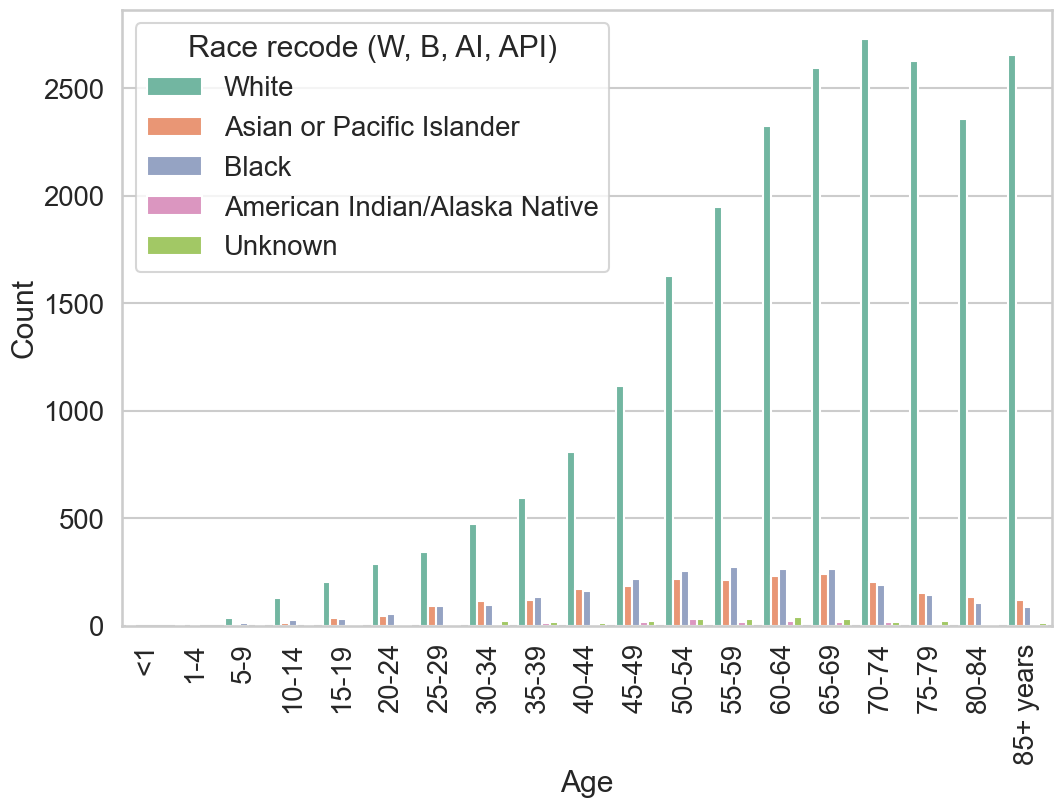

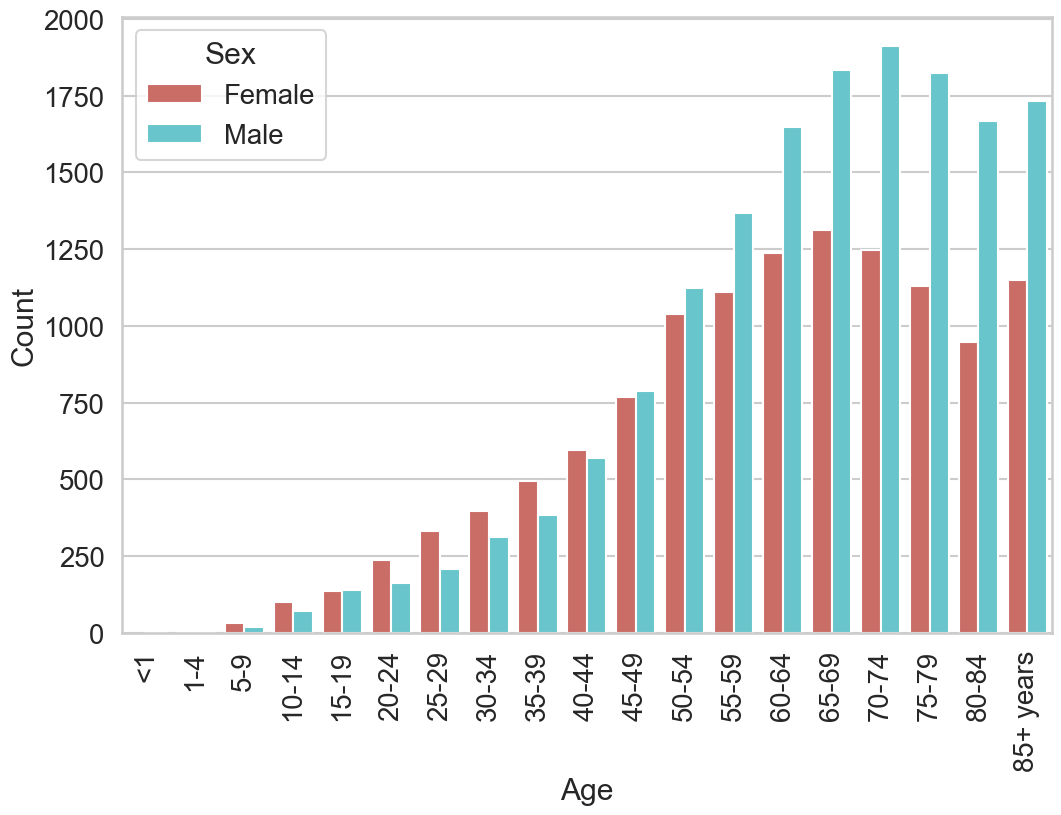

In [78]:

# Select relevant columns for demographic analysis
demographic_columns = ['Age recode with <1 year olds', 'Race recode (W, B, AI, API)', 'Sex']

# Evaluate each column for missing values
print(salivary_df[demographic_columns[0]].unique())
print(salivary_df[demographic_columns[1]].unique())
print(salivary_df[demographic_columns[2]].unique())

# Original age categories and the desired new labels
age_mapping = {
    '00 years': '<1',
    '01-04 years': '1-4',
    '05-09 years': '5-9',
    '10-14 years': '10-14',
    '15-19 years': '15-19',
    '20-24 years': '20-24',
    '25-29 years': '25-29',
    '30-34 years': '30-34',
    '35-39 years': '35-39',
    '40-44 years': '40-44',
    '45-49 years': '45-49',
    '50-54 years': '50-54',
    '55-59 years': '55-59',
    '60-64 years': '60-64',
    '65-69 years': '65-69',
    '70-74 years': '70-74',
    '75-79 years': '75-79',
    '80-84 years': '80-84',
    '85+ years': '85+ years'
}

# Apply the mapping to the Age recode column
salivary_df['Age recode with <1 year olds'] = salivary_df['Age recode with <1 year olds'].replace(age_mapping)

# Create an ordered list of the new labels
age_order = list(age_mapping.values())

# Convert the Age recode column to a categorical type with ordered categories
salivary_df['Age recode with <1 year olds'] = pd.Categorical(
    salivary_df['Age recode with <1 year olds'], categories=age_order, ordered=True
)

# Sex order
sex_order = ['Female','Male']

# Convert Sex column to reflect new order
salivary_df['Sex'] = pd.Categorical(
    salivary_df['Sex'], categories=sex_order, ordered=True
)


# Create a summary for age, sex, and race
demographic_summary = salivary_df[demographic_columns].describe(include='all')

# Display the summary
display(demographic_summary)

# Plot - countplot
sns.set_context('talk',font_scale=1.2)
sns.set_palette('Set2')
plt.figure(figsize=(12, 8))
age_countplot = sns.countplot(
    data=salivary_df,
    x='Age recode with <1 year olds',
    hue='Race recode (W, B, AI, API)',
    order=age_order,
)
age_countplot.set_xticklabels(age_countplot.get_xticklabels(), rotation=90)
age_countplot.set_xlabel('Age')
age_countplot.set_ylabel('Count')

plt.figure(figsize=(12, 8))
age_countplot = sns.countplot(
    data=salivary_df,
    x='Age recode with <1 year olds',
    hue='Sex',
    order=age_order,
    palette='hls'
)
age_countplot.set_xticklabels(age_countplot.get_xticklabels(), rotation=90)
age_countplot.set_xlabel('Age')
age_countplot.set_ylabel('Count')

In [83]:
# Select relevant columns for clinical characteristics analysis
clinical_columns = [
    'Site recode ICD-O-3/WHO 2008',
    'Histologic Type ICD-O-3',
    'Histology recode - broad groupings',
    'Combined Summary Stage (2004+)',
    'Summary stage 2000 (1998-2017)',
    'RX Summ--Surg Prim Site (1998+)',
    'Radiation recode',
    'Chemotherapy recode (yes, no/unk)'
]

# Creating a summary for clinical characteristics
clinical_summary = salivary_df[clinical_columns].describe(include='all')

# Display the summary
display(clinical_summary)

clinical_summary['Histologic Type ICD-O-3'].value_counts()


,Site recode ICD-O-3/WHO 2008,Histologic Type ICD-O-3,Histology recode - broad groupings,Combined Summary Stage (2004+),Summary stage 2000 (1998-2017),RX Summ--Surg Prim Site (1998+),Radiation recode,"Chemotherapy recode (yes, no/unk)"
count,28030,28030.000000,28030,28030,28030,28030.000000,28030,28030
unique,6,NaN,38,6,5,NaN,8,2
top,Salivary Gland,NaN,8050-8089: squamous cell neoplasms,Localized,Localized,NaN,None/Unknown,No/Unknown
freq,24029,NaN,5163,11120,10284,NaN,13469,23439
mean,NaN,8505.047271,NaN,NaN,NaN,30.352301,NaN,NaN
std,NaN,536.707302,NaN,NaN,NaN,19.614591,NaN,NaN
min,NaN,8000.000000,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,8071.000000,NaN,NaN,NaN,27.000000,NaN,NaN
50%,NaN,8430.000000,NaN,NaN,NaN,33.000000,NaN,NaN
75%,NaN,8550.000000,NaN,NaN,NaN,41.000000,NaN,NaN


Histologic Type ICD-O-3
28030.000000    1
8505.047271     1
536.707302      1
8000.000000     1
8071.000000     1
8430.000000     1
8550.000000     1
9971.000000     1
Name: count, dtype: int64

In [84]:
# Rename columns for easier access (optional)
salivary_df.rename(columns={'Survival months': 'survival_time', 'Event indicator column': 'event_occurred'}, inplace=True)

# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the data into the model
kmf.fit(durations=salivary_df['survival_time'], event_observed=salivary_df['SEER other cause of death classification'])

# Plot the Kaplan-Meier survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


TypeError: Wrong dtype 'object'.

In [85]:
salivary_df['SEER other cause of death classification']

0        Dead (attributable to causes other than this c...
1        Dead (attributable to causes other than this c...
2                              Alive or dead due to cancer
3                              Alive or dead due to cancer
4                              Alive or dead due to cancer
                               ...                        
28025                          Alive or dead due to cancer
28026                          Alive or dead due to cancer
28027                          Alive or dead due to cancer
28028                          Alive or dead due to cancer
28029                          Alive or dead due to cancer
Name: SEER other cause of death classification, Length: 28030, dtype: object